In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import re
import scanpy as sc
from scipy.sparse import csr_matrix
import scvi
import torch
import seaborn as sns

# Load data

In [38]:
filename = '../data_out/matrix_filtered_nostim.h5ad'
adata = sc.read(filename)

In [4]:
adata

AnnData object with n_obs × n_vars = 30821 × 36601
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well'
    var: 'gene_ids', 'feature_types'

In [5]:
# Mas eficiente para entrenar
adata.X = csr_matrix(adata.X)

# Doublet removal
(two or more cells are mistakenly captured together and sequenced as if they were a single cell)

In [6]:
# Only keep genes with more than 10 cells
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 30821 × 19961
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well'
    var: 'gene_ids', 'feature_types', 'n_cells'

**Highly variable genes** are crucial in scRNA-seq because they capture the key biological **differences between** cells, making it easier to identify and distinguish different cell types, states, and pathways. By focusing on these genes, researchers can filter out noise, improve clustering, and gain more meaningful insights into cellular heterogeneity and function.

In [7]:
# Keep top highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')
adata

AnnData object with n_obs × n_vars = 30821 × 2000
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

### Train a model to find doublets

In [8]:
# %% First dimensionality reduction
torch.set_float32_matmul_precision('medium')
scvi.settings.dl_num_workers = 19
scvi.settings.batch_size = 512
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.to_device('cuda')
vae.train(batch_size=512)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/260 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=260` reached.


In [9]:
# The reduced dimensionality model outputs are used as imputs to a classifier
# https://docs.scvi-tools.org/en/stable/user_guide/models/solo.html
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train(batch_size=512)

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.186. Signaling Trainer to stop.


In [21]:
df = solo.predict(
    return_logits=True
)
df['prediction'] = solo.predict(soft=False)
df['dif'] = df.doublet - df.singlet
df

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction,dif
AAACCCACAACAAGAT-1,-1.584923,1.293011,singlet,-2.877934
AAACCCACAACGGCTC-1,-0.719013,0.933590,singlet,-1.652602
AAACCCACACCCTGTT-1,-0.757357,0.158498,singlet,-0.915854
AAACCCACACTATGTG-1,-2.061194,1.592620,singlet,-3.653814
AAACCCAGTACAGGTG-1,-1.559747,1.262997,singlet,-2.822744
...,...,...,...,...
TTTGTTGAGTGGATAT-4,-2.143745,2.319399,singlet,-4.463145
TTTGTTGCAAGACCGA-4,-1.785674,2.675807,singlet,-4.461481
TTTGTTGGTCGCAGTC-4,-3.948848,3.305552,singlet,-7.254400
TTTGTTGGTTGTGGAG-4,-2.721175,2.158995,singlet,-4.880170


In [22]:
print((df['prediction'] == 'singlet').sum()/len(df))
df.value_counts('prediction')
# 0.8597384899905909

0.8742091431167062


prediction
singlet    26944
doublet     3877
Name: count, dtype: int64

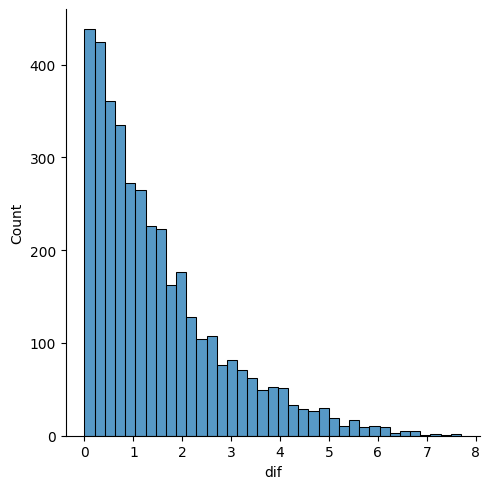

In [23]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

<Axes: >

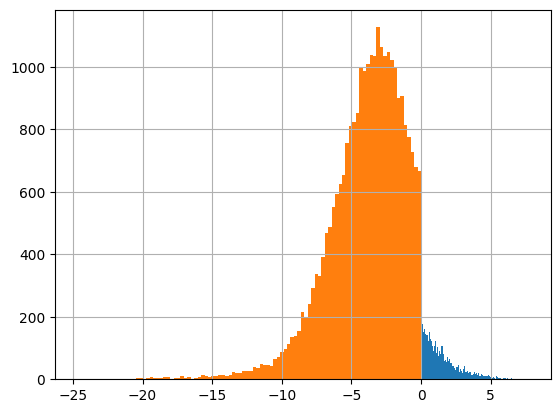

In [29]:
bins = 100
df[df['prediction']=='doublet']['dif'].hist(bins=bins)
df[df['prediction']=='singlet']['dif'].hist(bins=bins)

In [36]:
doublets = df[
    (df.prediction == 'doublet') &
    (df.dif > 1)
]
print(1 - len(doublets)/len(df))

0.931637519872814


In [57]:
doublets.to_csv(filename.replace('.h5ad', '_dublets.csv'))
doublets

,doublet,singlet,prediction,dif
AAAGGATAGGTTGCCC-1,0.853676,-0.917157,doublet,1.770833
AAAGGTAAGGGCCCTT-1,0.926202,-0.921239,doublet,1.847442
AAAGTCCAGGGCAAGG-1,0.945896,-0.666171,doublet,1.612067
AACAACCAGCAATTCC-1,0.852919,-0.535504,doublet,1.388423
AACAACCCAAGTACCT-1,2.656450,-2.149479,doublet,4.805929
...,...,...,...,...
TTGTTGTGTTGCTTGA-4,1.760906,-1.545551,doublet,3.306457
TTTACGTCATCACGGC-4,1.913056,-1.762698,doublet,3.675754
TTTATGCGTGGAATGC-4,2.008852,-1.969522,doublet,3.978374
TTTGACTGTGCTTATG-4,0.529238,-1.014940,doublet,1.544177


In [131]:
# Add dublets to obs
adata = sc.read(
    filename,
    cache=True,
    gex_only=False,
    # make_unique=True
)
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata

AnnData object with n_obs × n_vars = 30821 × 36601
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet'
    var: 'gene_ids', 'feature_types'

In [132]:
# Aca obtenemos un número mas parecido al paper en cuanto a celulas
adata = adata[~adata.obs['doublet']]
adata

View of AnnData object with n_obs × n_vars = 28714 × 36601
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet'
    var: 'gene_ids', 'feature_types'

# Preprocessing

In [133]:
# Mitocondrial, 13
adata.var['mt'] = adata.var.index.str.startswith('MT-')
adata.var.value_counts('mt')

/tmp/ipykernel_1099171/558155064.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


mt
False    36588
True        13
Name: count, dtype: int64

In [134]:
# Ribosomal Genes
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes


,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [135]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var.value_counts('ribo')

ribo
False    36514
True        87
Name: count, dtype: int64

In [136]:
adata.var

,gene_ids,feature_types,mt,ribo
MIR1302-2HG,ENSG00000243485,Gene Expression,False,False
FAM138A,ENSG00000237613,Gene Expression,False,False
OR4F5,ENSG00000186092,Gene Expression,False,False
AL627309.1,ENSG00000238009,Gene Expression,False,False
AL627309.3,ENSG00000239945,Gene Expression,False,False
...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,False,False
AC023491.2,ENSG00000278633,Gene Expression,False,False
AC007325.1,ENSG00000276017,Gene Expression,False,False
AC007325.4,ENSG00000278817,Gene Expression,False,False


In [137]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [138]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,False,False,0,0.000000,100.000000,0.0
OR13F1,ENSG00000186881,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL450426.1,ENSG00000283001,Gene Expression,False,False,0,0.000000,100.000000,0.0
OR13C4,ENSG00000148136,Gene Expression,False,False,0,0.000000,100.000000,0.0
OR13C3,ENSG00000204246,Gene Expression,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...
MT-CO3,ENSG00000198938,Gene Expression,True,False,28703,111.654770,0.038309,3206055.0
MT-CO1,ENSG00000198804,Gene Expression,True,False,28705,90.712997,0.031344,2604733.0
MT-CO2,ENSG00000198712,Gene Expression,True,False,28705,94.607788,0.031344,2716568.0
MT-ATP6,ENSG00000198899,Gene Expression,True,False,28706,79.000488,0.027861,2268420.0


In [86]:
# Esto se pude descomentar para analisis local pero mejor comentarlo a nivel global
# sc.pp.filter_genes(adata, min_cells=3)
# adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AC079341.2,ENSG00000261501,Gene Expression,False,False,3,0.000104,99.989552,3.0,3
PCDHGA3,ENSG00000254245,Gene Expression,False,False,3,0.000104,99.989552,3.0,3
AC069281.1,ENSG00000225807,Gene Expression,False,False,3,0.000139,99.989552,4.0,3
SNTG2-AS1,ENSG00000235688,Gene Expression,False,False,3,0.000104,99.989552,3.0,3
AC092159.1,ENSG00000227713,Gene Expression,False,False,3,0.000104,99.989552,3.0,3
...,...,...,...,...,...,...,...,...,...
MT-CO3,ENSG00000198938,Gene Expression,True,False,28703,111.654770,0.038309,3206055.0,28703
MT-CO2,ENSG00000198712,Gene Expression,True,False,28705,94.607788,0.031344,2716568.0,28705
MT-CO1,ENSG00000198804,Gene Expression,True,False,28705,90.712997,0.031344,2604733.0,28705
MT-ATP6,ENSG00000198899,Gene Expression,True,False,28706,79.000488,0.027861,2268420.0,28706


In [139]:
adata.obs.sort_values('n_genes_by_counts')

,condition,crispr,guide_id,gene,well,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TGCGGCAGTGTTAAAG-1,Nostim,perturbed,FOXL2NB-2,FOXL2NB,1,False,143,658.0,508.0,77.203651,32.0,4.863222
TCTACCGTCGATGCTA-1,Nostim,perturbed,P2RY14-1,P2RY14,1,False,146,680.0,508.0,74.705879,40.0,5.882353
CCTCCAAAGGGCGAAG-4,Nostim,perturbed,PRDM13-1,PRDM13,4,False,158,739.0,579.0,78.349121,17.0,2.300406
TCGAACATCATGCCGG-1,Nostim,perturbed,CBY1-1,CBY1,1,False,195,949.0,731.0,77.028450,19.0,2.002108
AGGATAAAGCCTCCAG-3,Nostim,perturbed,CNR2-1,CNR2,3,False,199,2079.0,1872.0,90.043289,15.0,0.721501
...,...,...,...,...,...,...,...,...,...,...,...,...
TGAATGCGTGATACCT-3,Nostim,perturbed,LHX6-1,LHX6,3,False,6200,33381.0,2453.0,7.348492,4903.0,14.687996
CTACAGAGTACCTTCC-4,Nostim,perturbed,TNFRSF9-1,TNFRSF9,4,False,6489,40616.0,2858.0,7.036636,6529.0,16.074947
CATGGATCAACACTAC-2,Nostim,perturbed,TNFRSF1B-2,TNFRSF1B,2,False,6602,38998.0,2924.0,7.497820,6271.0,16.080313
TACTGCCCAGGAATCG-1,Nostim,perturbed,CD27-2,CD27,1,False,6915,51794.0,4488.0,8.665096,8231.0,15.891802


In [140]:
sc.pp.filter_cells(adata, min_genes=200)
adata.obs.sort_values('n_genes_by_counts')

,condition,crispr,guide_id,gene,well,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
TTAGTCTTCAGTCCGG-2,Nostim,perturbed,LHX4-1,LHX4,2,False,201,936.0,713.0,76.175217,18.0,1.923077,201
AGTTAGCTCGCTGTCT-1,Nostim,perturbed,DEPDC7-1,DEPDC7,1,False,204,588.0,360.0,61.224491,16.0,2.721088,204
TTCTTCCCACCCTTAC-4,Nostim,perturbed,OTUD7B-2,OTUD7B,4,False,207,1025.0,764.0,74.536583,17.0,1.658536,207
AATCGTGAGTTGCGCC-4,Nostim,perturbed,PIK3AP1-1,PIK3AP1,4,False,215,482.0,235.0,48.755188,16.0,3.319502,215
GCGGATCTCAAACGTC-2,Nostim,perturbed,CD2-1,CD2,2,False,215,864.0,638.0,73.842590,28.0,3.240741,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGAATGCGTGATACCT-3,Nostim,perturbed,LHX6-1,LHX6,3,False,6200,33381.0,2453.0,7.348492,4903.0,14.687996,6200
CTACAGAGTACCTTCC-4,Nostim,perturbed,TNFRSF9-1,TNFRSF9,4,False,6489,40616.0,2858.0,7.036636,6529.0,16.074947,6489
CATGGATCAACACTAC-2,Nostim,perturbed,TNFRSF1B-2,TNFRSF1B,2,False,6602,38998.0,2924.0,7.497820,6271.0,16.080313,6602
TACTGCCCAGGAATCG-1,Nostim,perturbed,CD27-2,CD27,1,False,6915,51794.0,4488.0,8.665096,8231.0,15.891802,6915


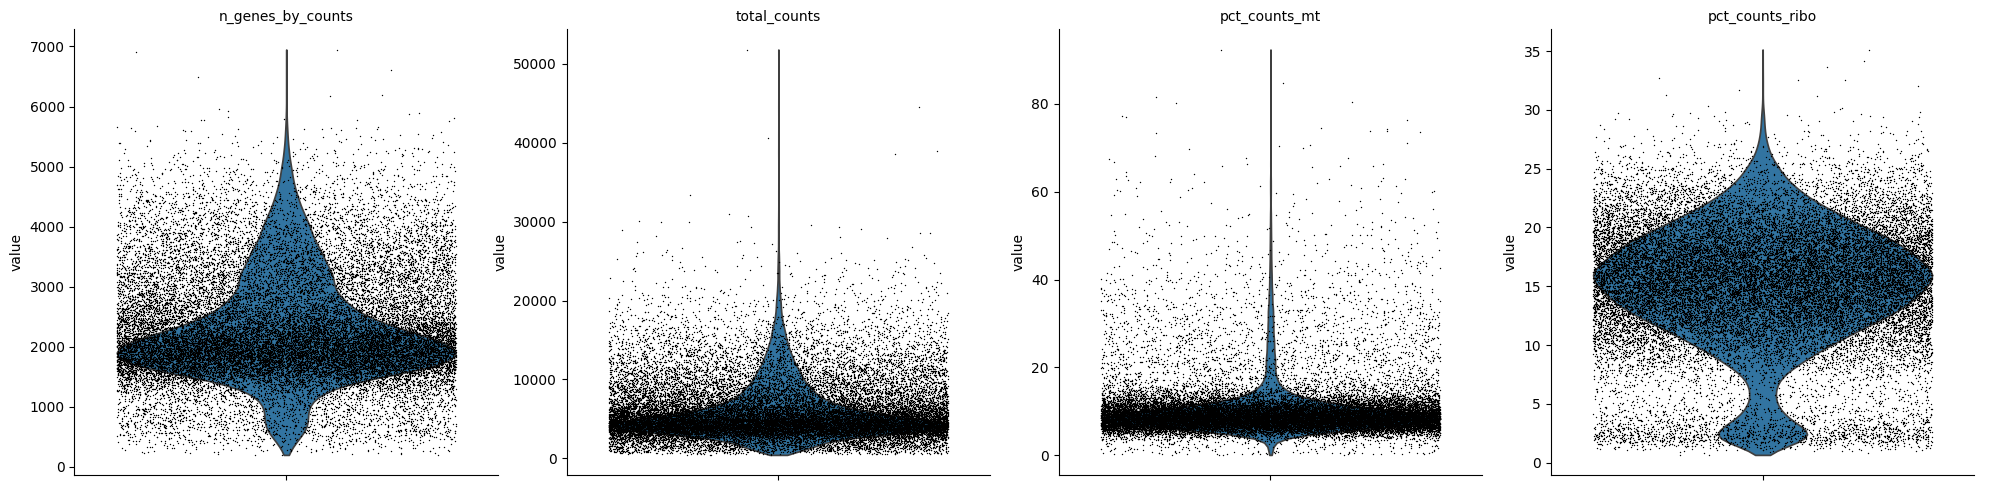

In [141]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [142]:
import numpy as np
upper_lim_n_genes_by_counts = np.quantile(adata.obs.n_genes_by_counts.values, .98)
upper_lim_total_counts = np.quantile(adata.obs.total_counts.values, .98)
upper_lim_pct_counts_mt = np.quantile(adata.obs.pct_counts_mt.values, .98)
upper_lim_pct_counts_ribo = np.quantile(adata.obs.pct_counts_ribo.values, .98)
upper_lim_n_genes_by_counts, upper_lim_total_counts, upper_lim_pct_counts_mt, upper_lim_pct_counts_ribo


(4528.0, 16802.56, 33.822642211914065, 24.383156814575194)

In [143]:
adata = adata[adata.obs.n_genes_by_counts < 5000]
adata

View of AnnData object with n_obs × n_vars = 28516 × 36601
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [144]:
adata = adata[adata.obs.pct_counts_mt < 25]
adata

View of AnnData object with n_obs × n_vars = 27273 × 36601
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [145]:
adata = adata[(adata.obs.pct_counts_ribo > 6) & (adata.obs.pct_counts_ribo < 25)]
adata

View of AnnData object with n_obs × n_vars = 25937 × 36601
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

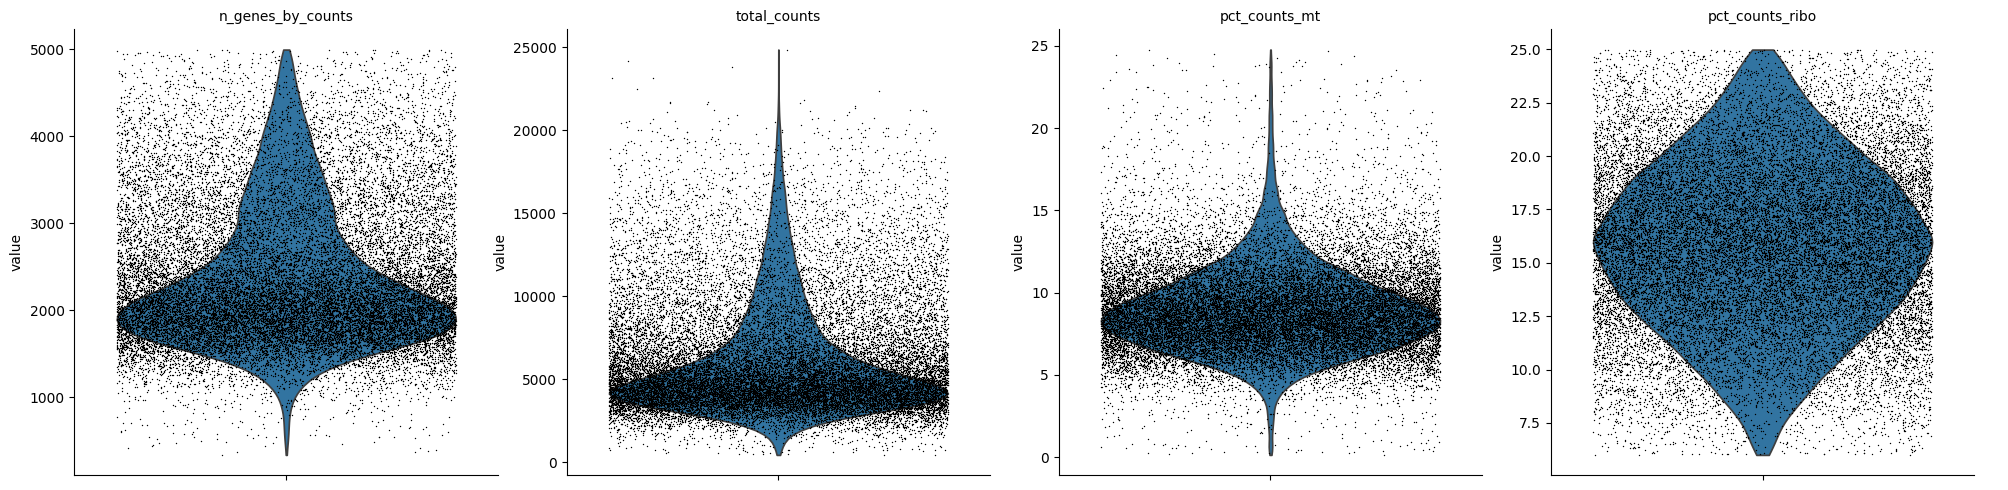

In [146]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [147]:
filename.replace('.h5ad', '_after_filtering.h5ad')
sc.write(filename.replace('.h5ad', '_after_filtering.h5ad'), adata)

# Normalization

In [102]:
adata.X.sum(axis = 1).max(), adata.X.sum(axis = 1).mean(), adata.X.sum(axis = 1).std(), adata.X.sum(axis = 1).min()

(24862.0, 6191.92, 3414.367, 439.0)

In [103]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [104]:
adata.X.sum(axis = 1)

matrix([[ 9999.982],
        [10000.108],
        [ 9999.923],
        ...,
        [ 9999.854],
        [10000.008],
        [10000.021]], dtype=float32)

In [105]:
sc.pp.log1p(adata) #change to log counts
adata.X.sum(axis = 1)

matrix([[2915.2373],
        [3760.396 ],
        [3627.5815],
        ...,
        [3734.398 ],
        [2776.506 ],
        [3184.726 ]], dtype=float32)

In [106]:
adata.raw = adata

In [107]:
adata.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 61642898 stored elements and shape (25937, 22867)>

In [108]:
adata

AnnData object with n_obs × n_vars = 25937 × 22867
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

# Clustering

In [109]:
# Esto no corta sino que agrega un flag
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [110]:
adata.var

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,False,False,61,0.002124,99.787560,61.0,61,False,0.003521,0.725017,-0.197063
AL627309.3,ENSG00000239945,Gene Expression,False,False,10,0.000348,99.965174,10.0,10,False,0.000646,0.640028,-0.499460
AL627309.5,ENSG00000241860,Gene Expression,False,False,330,0.011736,98.850735,337.0,330,False,0.020113,0.772040,-0.029752
AL627309.4,ENSG00000241599,Gene Expression,False,False,8,0.000279,99.972139,8.0,8,False,0.000410,0.709235,-0.253217
AL669831.2,ENSG00000229905,Gene Expression,False,False,5,0.000174,99.982587,5.0,5,False,0.000314,0.807469,0.096308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000273748,Gene Expression,False,False,481,0.016995,98.324859,488.0,481,False,0.033103,0.826749,0.164906
AC240274.1,ENSG00000271254,Gene Expression,False,False,120,0.004910,99.582085,141.0,120,False,0.008172,0.814712,0.122078
AC004556.3,ENSG00000276345,Gene Expression,False,False,2869,0.110538,90.008358,3174.0,2869,False,0.152565,0.637954,-0.506838
AC136616.1,ENSG00000273554,Gene Expression,False,False,4,0.000139,99.986070,4.0,4,False,0.000138,0.806898,0.094277


In [112]:
adata

AnnData object with n_obs × n_vars = 25937 × 22867
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

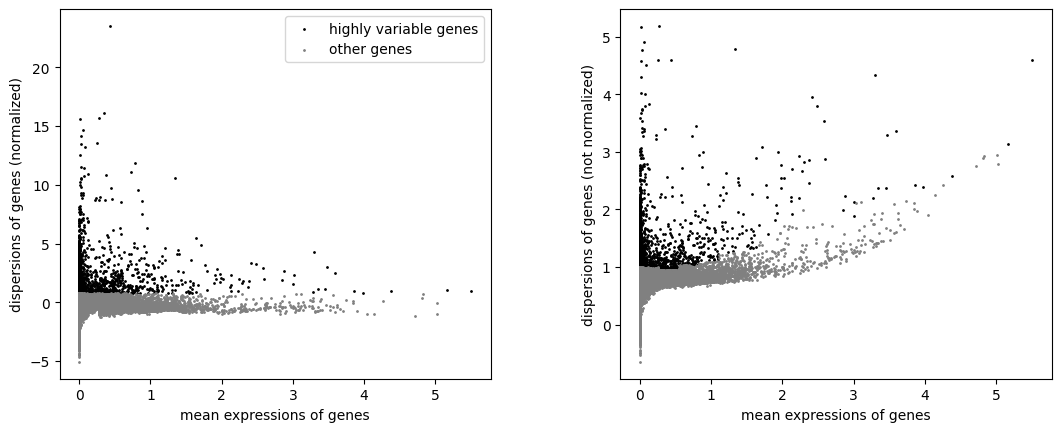

In [111]:
sc.pl.highly_variable_genes(adata)

In [113]:
adata = adata[:, adata.var.highly_variable]
adata

In [114]:
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.regress_out.html
# Linear Regression
# Creo que tiene que ver con 'pct_counts_mt', 'pct_counts_ribo' que se pueden usar como referencia
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [115]:
sc.pp.scale(adata, max_value=10)

In [116]:
sc.tl.pca(adata, svd_solver='arpack')

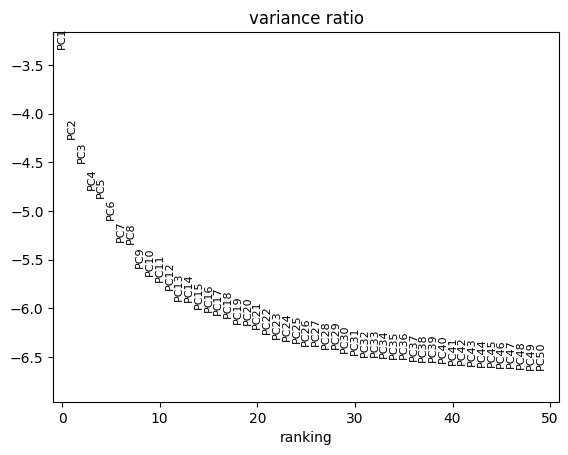

In [117]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [118]:
sc.pp.neighbors(adata, n_pcs = 30)

In [125]:
display(adata.obsp['distances'])
display(adata.obsp['connectivities'])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 414992 stored elements and shape (25937, 25937)>

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 585790 stored elements and shape (25937, 25937)>

In [126]:
sc.tl.umap(adata)

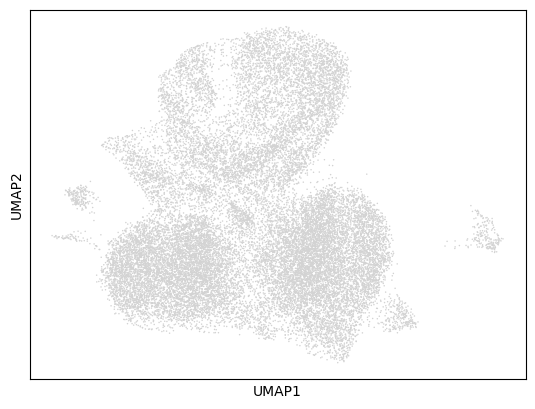

In [127]:
sc.pl.umap(adata)

In [128]:
sc.tl.leiden(adata, resolution = 0.5)

/tmp/ipykernel_1099171/3246266323.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


In [129]:
adata.obs

,condition,crispr,guide_id,gene,well,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden
AAACCCACAACAAGAT-1,Nostim,perturbed,PLCG2-2,PLCG2,1,False,1826,3651.0,397.0,10.873734,423.0,11.585867,1825,4
AAACCCACAACGGCTC-1,Nostim,perturbed,HELZ2-1,HELZ2,1,False,3706,11032.0,1108.0,10.043510,1205.0,10.922771,3705,2
AAACCCACACCCTGTT-1,Nostim,perturbed,OTUD7B-1,OTUD7B,1,False,3439,9719.0,635.0,6.533594,1324.0,13.622801,3439,2
AAACCCACACTATGTG-1,Nostim,perturbed,CD247-1,CD247,1,False,1794,4043.0,296.0,7.321296,763.0,18.872124,1794,0
AAACCCAGTACAGGTG-1,Nostim,perturbed,PRKD2-1,PRKD2,1,False,2656,5859.0,413.0,7.048985,496.0,8.465609,2655,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGCTTTCCC-4,Nostim,perturbed,CBY1-2,CBY1,4,False,830,1381.0,198.0,14.337437,137.0,9.920347,830,0
TTTGTTGAGTGGATAT-4,Nostim,perturbed,WT1-1,WT1,4,False,2782,7064.0,530.0,7.502831,716.0,10.135900,2782,2
TTTGTTGCAAGACCGA-4,Nostim,perturbed,TNFRSF1A-2,TNFRSF1A,4,False,3649,10544.0,925.0,8.772762,771.0,7.312215,3649,2
TTTGTTGGTTGTGGAG-4,Nostim,perturbed,EMP3-2,EMP3,4,False,1734,3778.0,332.0,8.787719,702.0,18.581259,1734,0


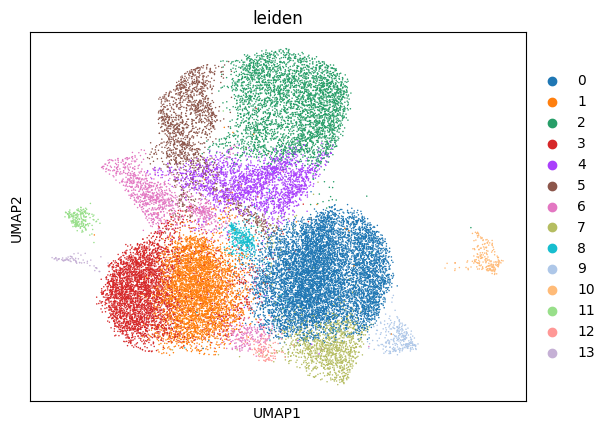

In [130]:
sc.pl.umap(adata, color=['leiden'])